In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from datetime import datetime 
import multiprocessing
from bs4 import BeautifulSoup as bs
from selectolax.parser import HTMLParser
import re
import pymorphy2
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string
import pickle


#preprocessing
import re
import pymorphy2
import nltk
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet
import matplotlib.pyplot as plt
import string

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from livelossplot.tf_keras import PlotLossesCallback
from time import time  # To time our operations
from collections import defaultdict, Counter  # For word frequency


import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

# import logging  # Setting up the loggings to monitor gensim
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/adwiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/adwiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Data loading and preparation
data = pd.read_json('../datasets/dataset.json')
mapping = {False: 0, True: 1}
data.replace({'hasBadWords': mapping}, inplace=True)
# data.hasBadWords = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
data.rename(columns={"hasBadWords": "labels"}, inplace=True)
data.drop(['violation'], axis=1, inplace=True)
data.shape

RANDOM_STATE = 42

data = shuffle(data, random_state=RANDOM_STATE).reset_index(drop=True)
# data=data[:10000]
data.shape

(86439, 2)

In [4]:
data.head()

,text,labels
0,Hot guy jacks off for you with toys!!!!,0
1,Zillemdom,0
2,"CUM COUNTDOWN, VAPING, CUCKOLDING, PUSSY SLAPP...",0
3,<p>Lilith gives POV Findom and humilation to v...,0
4,"<body topmargin=""0"">\r\n<div align=""center"">\r...",0


# Preprocessing function

In [5]:
# function to clean and pre-process the text.
def clean_text(text):  
    
    # 1. Removing html tags
    text = bs(text,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    text = re.sub("[^a-zA-Z]"," ", text)
    
    # 3. Converting to lower case and splitting
    word_tokens = text.lower().split()
    
    # 4. Remove stopwords
    le = WordNetLemmatizer()
    stop_words = set(stopwords.words("english")+ ['14000kbps', 'november', '1080p', 'email', 
                                                 '4k', 'mp4', 'error', '404', '2022'])     
    word_tokens = [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review = " ".join(word_tokens)
    return cleaned_review

In [6]:
data[:100].apply(lambda row: clean_text(row.text), axis=1)

0                                      hot guy jack toy
1                                             zillemdom
2     cum countdown vaping cuckolding pussy slapping...
3     lilith give pov findom humilation viewer deept...
4     welcome clipstore get meet face behind first t...
                            ...                        
95    new foot tall ol lady punish bos giantess femd...
96                      shoeplay dipping checked tights
97    tickling bondage foot foot toe sole shoe stock...
98                                 footjob extravaganza
99                       horny housewife helen xxx clip
Length: 100, dtype: object

In [7]:
data['text_preprocessed'] = data.apply(lambda row: clean_text(row.text), axis=1)

In [8]:
data

,text,labels,text_preprocessed
0,Hot guy jacks off for you with toys!!!!,0,hot guy jack toy
1,Zillemdom,0,zillemdom
2,"CUM COUNTDOWN, VAPING, CUCKOLDING, PUSSY SLAPP...",0,cum countdown vaping cuckolding pussy slapping...
3,<p>Lilith gives POV Findom and humilation to v...,0,lilith give pov findom humilation viewer deept...
4,"<body topmargin=""0"">\r\n<div align=""center"">\r...",0,welcome clipstore get meet face behind first t...
...,...,...,...
86434,<p>Double the treat my pregnant belly and my w...,0,double treat pregnant belly wrinkled sol right...
86435,"Fetishes, Sex & Naughty Fun!",0,fetish sex naughty fun
86436,PassionXcouple OnlyFans,1,passionxcouple onlyfans
86437,GF Caught You Wearing Her Panties,0,gf caught wearing panty


In [9]:
data = data[['text_preprocessed', 'labels', 'text']] # columns reorder

In [10]:
data.head()

,text_preprocessed,labels,text
0,hot guy jack toy,0,Hot guy jacks off for you with toys!!!!
1,zillemdom,0,Zillemdom
2,cum countdown vaping cuckolding pussy slapping...,0,"CUM COUNTDOWN, VAPING, CUCKOLDING, PUSSY SLAPP..."
3,lilith give pov findom humilation viewer deept...,0,<p>Lilith gives POV Findom and humilation to v...
4,welcome clipstore get meet face behind first t...,0,"<body topmargin=""0"">\r\n<div align=""center"">\r..."


In [11]:
# data.to_csv('../datasets/clear_text.csv')

# Tensorflow

In [12]:
# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count  

In [13]:
counter = counter_word(data.text_preprocessed)  

In [14]:
data.text_preprocessed

0                                         hot guy jack toy
1                                                zillemdom
2        cum countdown vaping cuckolding pussy slapping...
3        lilith give pov findom humilation viewer deept...
4        welcome clipstore get meet face behind first t...
                               ...                        
86434    double treat pregnant belly wrinkled sol right...
86435                               fetish sex naughty fun
86436                              passionxcouple onlyfans
86437                              gf caught wearing panty
86438                       stink one night stand bathroom
Name: text_preprocessed, Length: 86439, dtype: object

In [15]:
num_unique_words = len(counter)
oov_token = '<UNK>'

In [16]:
num_unique_words

52659

In [17]:
counter['deadly']

3

In [18]:
counter.most_common(150)

[('foot', 40360),
 ('fetish', 26751),
 ('clip', 19402),
 ('as', 13295),
 ('video', 13142),
 ('girl', 12521),
 ('big', 10888),
 ('domination', 10362),
 ('store', 9679),
 ('cum', 9484),
 ('worship', 8710),
 ('cock', 8055),
 ('bondage', 8010),
 ('slave', 7865),
 ('face', 7550),
 ('heel', 7507),
 ('sexy', 7186),
 ('female', 7086),
 ('get', 6951),
 ('pussy', 6791),
 ('femdom', 6740),
 ('high', 6627),
 ('balloon', 6503),
 ('woman', 6188),
 ('toe', 6123),
 ('leg', 5951),
 ('sex', 5755),
 ('tit', 5650),
 ('humiliation', 5643),
 ('pantyhose', 5563),
 ('sol', 5515),
 ('shoe', 5316),
 ('boot', 5308),
 ('mistress', 5179),
 ('stocking', 5137),
 ('blow', 5093),
 ('like', 4923),
 ('play', 4909),
 ('time', 4856),
 ('pov', 4779),
 ('amateur', 4726),
 ('goddess', 4691),
 ('hot', 4634),
 ('want', 4557),
 ('make', 4538),
 ('milf', 4496),
 ('panty', 4449),
 ('sock', 4447),
 ('fart', 4445),
 ('tickling', 4374),
 ('fuck', 4366),
 ('fucking', 4336),
 ('crush', 4329),
 ('mouth', 4312),
 ('hand', 4286),
 ('love

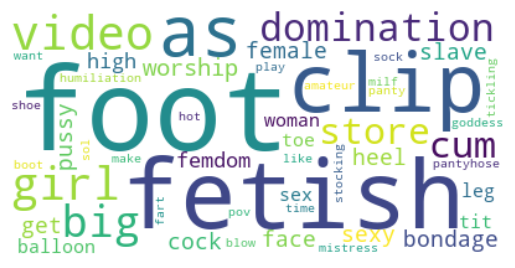

In [19]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [20]:
train_size = int(data.shape[0] * .8)

train = data[:train_size]
val = data[train_size:]

# Split train and test

X_train = train.text_preprocessed.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text_preprocessed.to_numpy()
y_val = val.labels.to_numpy()

In [21]:
train.text_preprocessed.to_numpy()

array(['hot guy jack toy', 'zillemdom',
       'cum countdown vaping cuckolding pussy slapping lingerie as british red brunette femdom tease pov roleplay heel smoking british accent',
       ...,
       'danielle wearing mini skirt see blue panty also wearing little sport top fishnet white platform boot scissors slave really hard clip sexy strong powerful leg look face turn normal color deep purple girl extremely strong leg could end life',
       'tongue fetish sun shine',
       'cbt high heel reward tiny dick chastity hd wmv'], dtype=object)

In [22]:
X_train,  y_train

(array(['hot guy jack toy', 'zillemdom',
        'cum countdown vaping cuckolding pussy slapping lingerie as british red brunette femdom tease pov roleplay heel smoking british accent',
        ...,
        'danielle wearing mini skirt see blue panty also wearing little sport top fishnet white platform boot scissors slave really hard clip sexy strong powerful leg look face turn normal color deep purple girl extremely strong leg could end life',
        'tongue fetish sun shine',
        'cbt high heel reward tiny dick chastity hd wmv'], dtype=object),
 array([0, 0, 0, ..., 0, 0, 0]))

In [23]:
X_train.shape, X_val.shape

((69151,), (17288,))

# Tokenize

In [24]:
# vectorize a text corpus by turning each text into sentence of integers

tokenizer = Tokenizer(num_words=num_unique_words) #, oov_token=oov_token)
tokenizer.fit_on_texts(data.text_preprocessed.to_numpy())

In [58]:
import pickle

# # saving
# with open('../models/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [62]:
word_index = dict()
for word, number in tokenizer.word_index.items():
    word_index[word] = number + 3

word_index["<PAD>"] = 0    
word_index["<BEGINOFSEQUENCE>"] = 1
word_index["<UNKNOWN>"] = 2

# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])


# Последовательность индексов в текст
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

# Текст в последовательность индексов
def encode(sequence):
    words = sequence.lower().split()
    words = ["<BEGINOFSEQUENCE>"] + words
    idxs = [word_index.get(word, word_index["<UNKNOWN>"]) for word in words]
    return idxs

In [63]:
word_index['foot']

4

In [64]:
reverse_word_index[4]

'foot'

In [65]:
reverse_word_index

{4: 'foot',
 5: 'fetish',
 6: 'clip',
 7: 'as',
 8: 'video',
 9: 'girl',
 10: 'big',
 11: 'domination',
 12: 'store',
 13: 'cum',
 14: 'worship',
 15: 'cock',
 16: 'bondage',
 17: 'slave',
 18: 'face',
 19: 'heel',
 20: 'sexy',
 21: 'female',
 22: 'get',
 23: 'pussy',
 24: 'femdom',
 25: 'high',
 26: 'balloon',
 27: 'woman',
 28: 'toe',
 29: 'leg',
 30: 'sex',
 31: 'tit',
 32: 'humiliation',
 33: 'pantyhose',
 34: 'sol',
 35: 'shoe',
 36: 'boot',
 37: 'mistress',
 38: 'stocking',
 39: 'blow',
 40: 'like',
 41: 'play',
 42: 'time',
 43: 'pov',
 44: 'amateur',
 45: 'goddess',
 46: 'hot',
 47: 'want',
 48: 'make',
 49: 'milf',
 50: 'panty',
 51: 'sock',
 52: 'fart',
 53: 'tickling',
 54: 'fuck',
 55: 'fucking',
 56: 'crush',
 57: 'mouth',
 58: 'hand',
 59: 'love',
 60: 'see',
 61: 'black',
 62: 'orgasm',
 63: 'farting',
 64: 'job',
 65: 'tease',
 66: 'one',
 67: 'smoking',
 68: 'long',
 69: 'full',
 70: 'masturbation',
 71: 'spanking',
 72: 'hd',
 73: 'take',
 74: 'hard',
 75: 'dirty',
 7

In [66]:
word_index['sex']

30

In [67]:
len(word_index)

52662

# Find  vectors

In [32]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [33]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 256

X_train_padded = pad_sequences(X_train_sequences, 
                               value=word_index["<PAD>"], 
                               maxlen=max_length, 
                               padding="post", 
                               truncating="post")

X_val_padded = pad_sequences(X_val_sequences, 
                             value=word_index["<PAD>"], 
                             maxlen=max_length, 
                             padding="post", 
                             truncating="post")

X_train_padded.shape, X_val_padded.shape

print(f"Length examples: {[len(X_train_padded[10]), len(X_train_padded[11])]}")
print('=' * 50)
print(f"Entry example: {X_train_padded[10]}")

Length examples: [256, 256]
Entry example: [  365   297 22484     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0  

In [34]:
X_train_sequences[10]

[365, 297, 22484]

In [35]:
print(decode(X_train_sequences[10]))
print(encode(decode(X_train_sequences[10])))

many piss arabie
[1, 365, 297, 22484]


# Tensorflow

In [36]:
import numpy as np
from keras.layers import LSTM, Embedding, Dense, Dropout

model = keras.models.Sequential([
    Embedding(num_unique_words, 16, input_length=max_length),
    tf.keras.layers.Bidirectional(
        LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0)),
    tf.keras.layers.Bidirectional(    
        LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0)),
#     Dropout(0.5),
#     Dense(8),
#     Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

# model = keras.models.Sequential([
#     Embedding(num_unique_words, 16, input_length=max_length),
# #     tf.keras.layers.Bidirectional(
# #         LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
#     tf.keras.layers.Bidirectional(    
#         LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
# #     Dropout(0.5),
# #     Dense(8),
# #     Dropout(0.5),
#     Dense(1, activation='sigmoid'),
# ])

# model = keras.models.Sequential([
#     Embedding(num_unique_words, 16, input_length=max_length),
#     LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0.5), 
#     LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0.5),
#     Dense(1, activation='sigmoid'),
# ])

loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=.01)
metrics = ['accuracy']
# metrics = [tf.keras.metrics.BinaryAccuracy(),
#            tf.keras.metrics.FalseNegatives(),
#            tf.keras.metrics.FalsePositives(),
#           ]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

print(model.summary())

Metal device set to: Apple M2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 16)           842544    
                                                                 
 bidirectional (Bidirectiona  (None, 256, 128)         41472     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 982,961
Trainable params: 982,961
Non-trainable params: 0
_________________________________________________________________
None


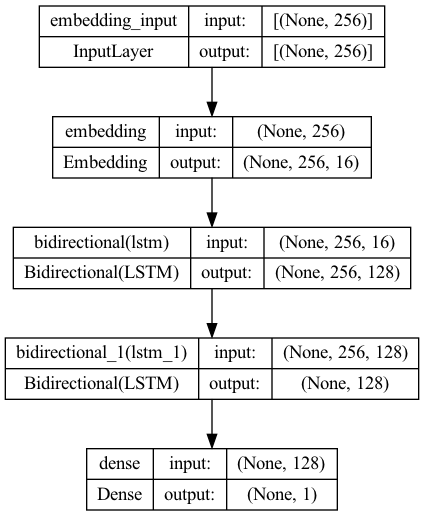

In [37]:
# draw model
tf.keras.utils.plot_model(model, show_shapes=True)

In [38]:
from pathlib import Path
from tensorflow.keras.models import load_model

path = Path('../models/bad_words')
path.mkdir(exist_ok=True) 
cpt_filename = '{epoch:02d}_checkpoint_{val_loss:.2f}.hdf5'
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_loss', verbose=1, 
                                                save_best_only=True, mode='min')

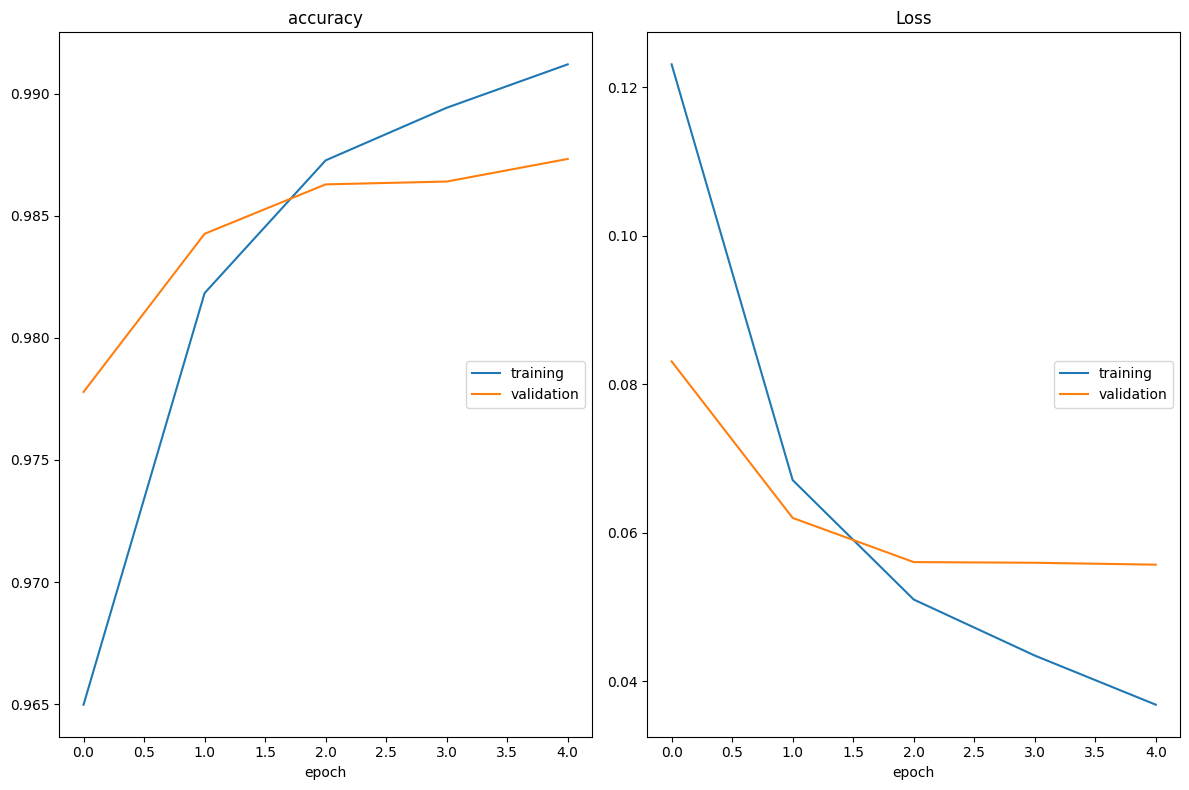

accuracy
	training         	 (min:    0.965, max:    0.991, cur:    0.991)
	validation       	 (min:    0.978, max:    0.987, cur:    0.987)
Loss
	training         	 (min:    0.037, max:    0.123, cur:    0.037)
	validation       	 (min:    0.056, max:    0.083, cur:    0.056)
136/136 [==============================] - 92s 673ms/step - loss: 0.0368 - accuracy: 0.9912 - val_loss: 0.0557 - val_accuracy: 0.9873


In [39]:
model.fit(X_train_padded, y_train, epochs=5, batch_size=512, validation_data=(X_val_padded, y_val), verbose=1, 
          callbacks=[checkpoint, PlotLossesCallback()])

In [40]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.123063,0.964975,0.083065,0.977788
1,0.067083,0.981837,0.061988,0.984267
2,0.050999,0.987274,0.056039,0.986291
3,0.043454,0.989429,0.055948,0.986407
4,0.036835,0.991208,0.055692,0.987332


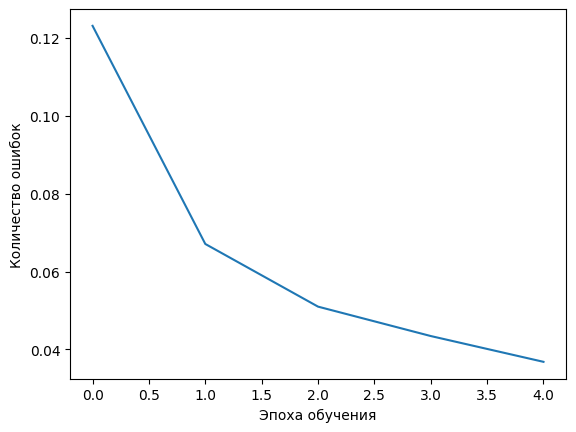

In [41]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss)
plt.xlabel('Эпоха обучения')
plt.ylabel('Количество ошибок');

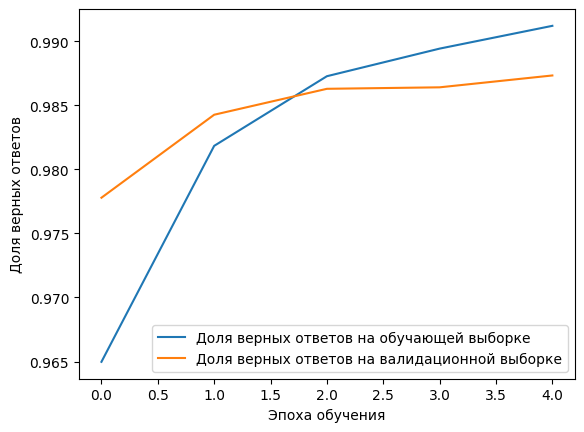

In [42]:
plt.plot(history_df.accuracy,
         label='Доля верных ответов на обучающей выборке')
plt.plot(history_df.val_accuracy,
         label='Доля верных ответов на валидационной выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [43]:
embeddlayers_matrix = model.layers[0].get_weights()[0]
embeddlayers_matrix[30]

array([-0.08048233, -0.653954  , -0.0310557 , -0.09473013,  0.04497065,
       -0.11538673, -0.22960934,  0.32349434, -0.01004625, -0.08712033,
        0.03680792, -0.10660435,  0.09936849, -0.15140136, -0.28660837,
       -0.13797553], dtype=float32)

In [74]:
word = 'sex'
word_numb = word_index[word]
print('Номер слова', word_numb)
print('Вектор для слова', embeddlayers_matrix[word_numb])

Номер слова 30
Вектор для слова [-0.08048233 -0.653954   -0.0310557  -0.09473013  0.04497065 -0.11538673
 -0.22960934  0.32349434 -0.01004625 -0.08712033  0.03680792 -0.10660435
  0.09936849 -0.15140136 -0.28660837 -0.13797553]


In [75]:
filename = '../datasets/embeds.csv'

In [98]:
word_index.values()

dict_values([4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [155]:
with open(filename, 'w') as f:
    for word_number in word_index.values():
        word = reverse_word_index[word_number-3]
        vec = embeddlayers_matrix[word_number-3]
        f.write(word + ',')
        f.write(','.join([str(x) for x in vec]) + '\n')

KeyError: -2

In [ ]:
!head -n30 $filename

In [80]:
reverse_word_index[30]

'sex'

In [81]:
!ls '../models/bad_words'

01_checkpoint_0.08.hdf5 02_checkpoint_0.06.hdf5 03_checkpoint_0.06.hdf5
01_checkpoint_0.17.hdf5 02_checkpoint_0.15.hdf5 04_checkpoint_0.06.hdf5
01_checkpoint_0.18.hdf5 02_checkpoint_0.17.hdf5 05_checkpoint_0.06.hdf5


In [82]:
model.load_weights('../models/bad_words/05_checkpoint_0.06.hdf5') # loading weights - model had created erlier
loss, acc = model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

541/541 [==============================] - 15s 27ms/step - loss: 0.0557 - accuracy: 0.9873
Accuracy of restored model 98.73%


In [83]:
base_model = tf.keras.models.load_model('../models/bad_words/05_checkpoint_0.06.hdf5')
# base_model.trainable = False # замораживаем базовую модель

loss, acc = base_model.evaluate(X_val_padded, y_val)
print(f'Accuracy of restored model {acc*100:.2f}%')

541/541 [==============================] - 14s 24ms/step - loss: 0.0557 - accuracy: 0.9873
Accuracy of restored model 98.73%


In [84]:
predictions = model.predict(X_train_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

2161/2161 [==============================] - 59s 27ms/step


In [85]:
X_train_padded[1200:1210]

array([[    6,   814,     1, ...,     0,     0,     0],
       [   65,   145,   630, ...,     0,     0,     0],
       [   37,  9577,   166, ...,     0,     0,     0],
       ...,
       [ 1391,  2991,   824, ...,     0,     0,     0],
       [30518,     0,     0, ...,     0,     0,     0],
       [ 2548,  1925,   229, ...,     0,     0,     0]], dtype=int32)

In [86]:
print(X_train[1200:1210])
print(y_train[1200:1210])
print(predictions[1200:1210])

['girl chick foot barefeet dirty foot sock pantyhose stocking nylon footfetish feetsmelling feetsniffing feetlicking worship foot'
 'long red toenail sexy heel'
 'like dainty way elai hold cigarette shy smile soft spoken reply confides think guy sexy smoke love smoking coming shoot elai started watching tube smoking clip understand sf interview talk smoking make feel sexy attractive men later end shoot elai mentioned crowned beauty queen province last year annual pageant'
 'wrestling scissorhold mixed wrestling scissorhold wrestling'
 'secret desire' 'lipstick smell delicious'
 'foot slave training submissive slave training human ashtray boot domination domination foot slave master boot human ashtray bdsm foot trampling spit men domination'
 'katy layla join ffw area battle round oil wrestling watch katy layla get oiled get dirty one kind match katy enjoys playing dirty hair pulling biting choking layla slouch able overpower katy throughout match enjoy first time debut lady want miss'


In [87]:
train['predictions'] = predictions
train = train[['text_preprocessed', 'labels', 'predictions', 'text']] # columns reorder

In [88]:
train.head(11)

,text_preprocessed,labels,predictions,text
0,hot guy jack toy,0,0,Hot guy jacks off for you with toys!!!!
1,zillemdom,0,0,Zillemdom
2,cum countdown vaping cuckolding pussy slapping...,0,0,"CUM COUNTDOWN, VAPING, CUCKOLDING, PUSSY SLAPP..."
3,lilith give pov findom humilation viewer deept...,0,0,<p>Lilith gives POV Findom and humilation to v...
4,welcome clipstore get meet face behind first t...,0,0,"<body topmargin=""0"">\r\n<div align=""center"">\r..."
5,nachricht fuer julia,0,0,Nachricht fuer Julia
6,soft delicious mobile,0,0,SOFT AND DELICIOUS 3 mobile
7,part stacy sexy petite teen clip get naked giv...,0,0,"<h4><strong>part 1, Stacy is a sexy, petite te..."
8,haider ali,0,0,Haider Ali
9,foot worship foot slave training foot worship ...,0,0,"FOOT WORSHIP, FOOT SLAVE TRAINING Foot wor..."


In [113]:
train.to_csv('../datasets/wo_html.csv')

In [ ]:
# model.save('../models/bad_words/modelSequential_HTML_final.h5')
# model = keras.models.load_model('../models/modelSequential_HTML_final.h5')

In [ ]:
# model_new = keras.models.load_model('../models/modelSequential_wo_HTML.h5')
# model_new = keras.models.load_model('../models/bad_words/08_checkpoint_0.07.hdf5')

In [ ]:
# with open('../datasets/sub.txt', 'r') as file:
#     raw_text = ''.join(file.readlines())

# raw_text

In [114]:
def read_train_data():
    data = pd.read_json('../datasets/dataset.json')
    mapping = {False: 0, True: 1}
    data.replace({'hasBadWords': mapping}, inplace=True)
    data.rename(columns={"hasBadWords": "labels"}, inplace=True)
    data.rename(columns={"text": "raw_text"}, inplace=True)
    data.drop(['violation'], axis=1, inplace=True)
    print('Data size %d' % len(data))
    print('Data headers %s' % data.columns.values)
    return data

In [115]:
df_pos = pd.read_csv('../datasets/BadWordsService_ml_has_7days.csv')
df_neg =  pd.read_csv('../datasets/BadWordsService_ml_has_no_7days.csv')
df_val = pd.read_csv('../datasets/BadWordsService_ml_has_today.csv')

In [116]:
df_pos.drop('@timestamp', axis=1, inplace=True)
df_neg.drop('@timestamp', axis=1, inplace=True)
df_val.drop('@timestamp', axis=1, inplace=True)
df_val['ctxt_.time_spent'] = df_val['ctxt_.time_spent'] * 1000 # convert seconds to milliseconds

In [117]:
df_pos.rename(columns={"ctxt_.text": "raw_text", "ctxt_.time_spent": "time_spent_ms"}, inplace=True)
df_neg.rename(columns={"ctxt_.text": "raw_text", "ctxt_.time_spent": "time_spent_ms"}, inplace=True)
df_val.rename(columns={"ctxt_.text": "raw_text"}, inplace=True)
df_val.rename(columns={"ctxt_.time_spent": "time_spent_ms"}, inplace=True)

In [118]:
df_pos.head()

,time_spent_ms,raw_text
0,0.1,<p>A sexy gagged waitress is brought in the ro...
1,0.0,"DID, ASS GRABBING, GROPING DAMSEL IN DISTRESS"
2,0.0,"KICKING, CBT, AMATEUR, HIGH HEELS BALL ABUSE"
3,0.6,start\tend\ttext\n280\t260\tThere's another on...
4,0.5,"<p><img src=""http://www.astrodomina.com/mdm/im..."


In [119]:
df_neg.head()

,time_spent_ms,raw_text
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...
2,0.1,Wicked Chicks Show To Their Little Servant How...
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI..."
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ..."


In [120]:
df_val.head()

,time_spent_ms,raw_text
0,100.0,<p>SSBBW Ivy Davenport and I know just how wea...
1,4600.0,start\tend\ttext\n0\t19000\tAre you ready?\n19...
2,2500.0,start\tend\ttext\n0\t1900\tVery fun!\n4800\t70...
3,0.0,brunette creampie MV IWC C4S.mp4
4,5800.0,start\tend\ttext\n0\t10640\tSo I see someone's...


In [121]:
df_pos['labels'] = 1
df_neg['labels'] = 0

In [122]:
df_pos.head()

,time_spent_ms,raw_text,labels
0,0.1,<p>A sexy gagged waitress is brought in the ro...,1
1,0.0,"DID, ASS GRABBING, GROPING DAMSEL IN DISTRESS",1
2,0.0,"KICKING, CBT, AMATEUR, HIGH HEELS BALL ABUSE",1
3,0.6,start\tend\ttext\n280\t260\tThere's another on...,1
4,0.5,"<p><img src=""http://www.astrodomina.com/mdm/im...",1


In [123]:
df_neg.head()

,time_spent_ms,raw_text,labels
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...,0
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...,0
2,0.1,Wicked Chicks Show To Their Little Servant How...,0
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI...",0
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ...",0


In [124]:
nan_values_neg = df_neg[df_neg.isna().any(axis=1)]
print(len(nan_values_neg))

# nan_values_pos = df_pos[df_pos.isna().any(axis=1)]
# print(len(nan_values_pos))

nan_values = df_val[df_val.isna().any(axis=1)]
print(len(nan_values))

221
0


In [125]:
df_neg.dropna(inplace=True)
df_neg.head()

,time_spent_ms,raw_text,labels
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...,0
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...,0
2,0.1,Wicked Chicks Show To Their Little Servant How...,0
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI...",0
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ...",0


In [126]:
df_pos['text'] = df_pos.apply(lambda row: clean_text(row.raw_text), axis=1)
df_neg['text'] = df_neg.apply(lambda row: clean_text(row.raw_text), axis=1)
df_val['text'] = df_val.apply(lambda row: clean_text(row.raw_text), axis=1)

In [127]:
df_pos.head()

,time_spent_ms,raw_text,labels,text
0,0.1,<p>A sexy gagged waitress is brought in the ro...,1,sexy gagged waitress brought room masked man s...
1,0.0,"DID, ASS GRABBING, GROPING DAMSEL IN DISTRESS",1,as grabbing groping damsel distress
2,0.0,"KICKING, CBT, AMATEUR, HIGH HEELS BALL ABUSE",1,kicking cbt amateur high heel ball abuse
3,0.6,start\tend\ttext\n280\t260\tThere's another on...,1,start end text another one erotic took side ri...
4,0.5,"<p><img src=""http://www.astrodomina.com/mdm/im...",1,hd x p step mom help homework boner pant hangi...


In [128]:
df_neg.head()

,time_spent_ms,raw_text,labels,text
0,0.2,<p>Wicked Chicks Show 2 Their Little Servant H...,0,wicked chick show little servant worship tasty...
1,0.1,Wicked Chicks Show 2 Their Little Servant How ...,0,wicked chick show little servant worship tasty...
2,0.1,Wicked Chicks Show To Their Little Servant How...,0,wicked chick show little servant worship tasty...
3,0.0,"ASS HUMILIATION, DOUBLE DOMINATION, ASS SNIFFI...",0,as humiliation double domination as sniffing t...
4,0.3,"<p>Nevada Max has beautiful, expressive eyes, ...",0,nevada max beautiful expressive eye going look...


In [129]:
df_val.head()

,time_spent_ms,raw_text,text
0,100.0,<p>SSBBW Ivy Davenport and I know just how wea...,ssbbw ivy davenport know weak big bubbly fart ...
1,4600.0,start\tend\ttext\n0\t19000\tAre you ready?\n19...,start end text ready yeah okay name seth old s...
2,2500.0,start\tend\ttext\n0\t1900\tVery fun!\n4800\t70...,start end text fun nice show stuff okay good d...
3,0.0,brunette creampie MV IWC C4S.mp4,brunette creampie mv iwc c mp
4,5800.0,start\tend\ttext\n0\t10640\tSo I see someone's...,start end text see someone enjoying back home ...


In [130]:
df_pos.drop('raw_text', axis=1, inplace=True)
df_neg.drop('raw_text', axis=1, inplace=True)
df_val.drop('raw_text', axis=1, inplace=True)

In [131]:
df_pos.shape, df_neg.shape, df_val.shape

((7746, 3), (31812, 3), (5255, 2))

In [132]:
from sklearn.utils import shuffle
RANDOM_STATE = 42

df_tra = pd.concat([df_pos, df_neg], ignore_index=True)
df_tra = shuffle(df_tra, random_state=RANDOM_STATE).reset_index(drop=True)

df_tra.shape

(39558, 3)

In [133]:
df_tra.head()

,time_spent_ms,labels,text
0,0.6,0,mean blonde girl sydney paige sits sub guy cha...
1,0.1,0,img mov
2,0.1,0,kicking slave hard humiliating insulting process
3,1.6,1,start end text appropriate oh today okay yes o...
4,0.1,0,return lance sole licker wmv


In [134]:
df_tra = df_tra[['text', 'labels']]#, 'raw_text']] # columns reorder
df_tra.head()

,text,labels
0,mean blonde girl sydney paige sits sub guy cha...,0
1,img mov,0
2,kicking slave hard humiliating insulting process,0
3,start end text appropriate oh today okay yes o...,1
4,return lance sole licker wmv,0


In [135]:
df_val.head()

,time_spent_ms,text
0,100.0,ssbbw ivy davenport know weak big bubbly fart ...
1,4600.0,start end text ready yeah okay name seth old s...
2,2500.0,start end text fun nice show stuff okay good d...
3,0.0,brunette creampie mv iwc c mp
4,5800.0,start end text see someone enjoying back home ...


In [136]:
counter

Counter({'hot': 4634,
         'guy': 1324,
         'jack': 391,
         'toy': 2691,
         'zillemdom': 1,
         'cum': 9484,
         'countdown': 391,
         'vaping': 18,
         'cuckolding': 413,
         'pussy': 6791,
         'slapping': 626,
         'lingerie': 1792,
         'as': 13295,
         'british': 348,
         'red': 1994,
         'brunette': 1551,
         'femdom': 6740,
         'tease': 3793,
         'pov': 4779,
         'roleplay': 502,
         'heel': 7507,
         'smoking': 3710,
         'accent': 90,
         'lilith': 91,
         'give': 2006,
         'findom': 589,
         'humilation': 92,
         'viewer': 62,
         'deepthroating': 13,
         'welcome': 930,
         'clipstore': 76,
         'get': 6951,
         'meet': 310,
         'face': 7550,
         'behind': 685,
         'first': 2269,
         'time': 4856,
         'porn': 2471,
         'amateur': 4726,
         'interview': 230,
         'girl': 12521,
      

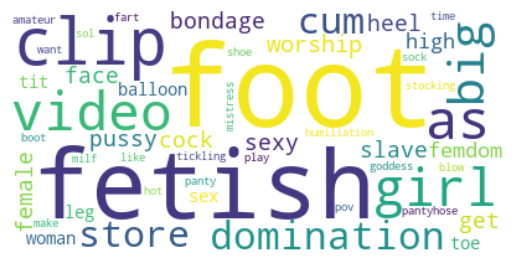

In [137]:
from wordcloud import *
word_freq = [i for i in counter.most_common(50)]
wd = WordCloud(background_color='white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [138]:
train_size = int(df_tra.shape[0] * .8)

train = df_tra[:train_size]
val = df_tra[train_size:]

# Split train and test

X_train = train.text.to_numpy()
y_train = train.labels.to_numpy()

X_val = val.text.to_numpy()
y_val = val.labels.to_numpy()

In [139]:
# X = df.text.to_numpy()

In [140]:
X_train,  y_train

(array(['mean blonde girl sydney paige sits sub guy charles knee tub ram foot throat calf flex pull stare face humiliating ram heel mouth ordering keep eye open face fuck wrap foot around neck foot neck seems begin retch threatens vomit peer face make look wrap hand behind head pull foot go throat sydney mean hot love demeaning charles quickly lock front headscissors turn purple go palm pouring hold figure four headscissors end pain foot sydney warns little skyler going happen find sher time',
        'img mov', 'kicking slave hard humiliating insulting process', ...,
        'starring thatty milly melissa raicca rafaela film full surprise thatty milly rope melissa start tickle milli change mind take control start tickle thatty enough milly invates friend studio enjoy party must watch film minute',
        'dehnuebung eins dein loch ist mir zu eng mp',
        'karol arrives home meet thatty sofa wating thatty asks punch belly karol start immediately punch thatty sexy belly dig deep to

In [141]:
X_train.shape, X_val.shape

((31646,), (7912,))

In [142]:
import pickle

# # loading
with open('../models/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [143]:
# vectorize a text corpus by turning each text into sentence of integers

# tokenizer = Tokenizer(num_words=num_unique_words) #, oov_token=oov_token)
# tokenizer.fit_on_texts(X)

In [144]:
# each word have a unique index
word_index = tokenizer.word_index
word_index['sex']

27

In [145]:
len(word_index.keys())

52659

In [146]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

In [147]:
print(X_train[1])
print(X_train_sequences[1])

img mov
[5007, 931]


In [148]:
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

# max words in a sequence
max_length = 200 #max([len(x) for x in X_train_sequences]) #256

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding="post", truncating="post")

X_train_padded.shape, X_val_padded.shape

((31646, 200), (7912, 200))

In [149]:
print(X_train[10])
print(X_train_sequences[10])
print(X_train_padded[10])

foot slave training foot worship foot humiliation toe sucking foot domination goddess grazi foot worship grazi gg producer girl foot foot slave training dirty foot foot slave foot humiliation foot gagging wrinkled sol foot foot odor foot domination foot fetish
[1, 14, 81, 1, 11, 1, 29, 25, 121, 1, 8, 42, 3495, 1, 11, 3495, 2264, 1371, 6, 1, 1, 14, 81, 72, 1, 1, 14, 1, 29, 1, 497, 510, 31, 1, 1, 3188, 1, 8, 1, 2]
[   1   14   81    1   11    1   29   25  121    1    8   42 3495    1
   11 3495 2264 1371    6    1    1   14   81   72    1    1   14    1
   29    1  497  510   31    1    1 3188    1    8    1    2    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

In [150]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
reverse_word_index

{1: 'foot',
 2: 'fetish',
 3: 'clip',
 4: 'as',
 5: 'video',
 6: 'girl',
 7: 'big',
 8: 'domination',
 9: 'store',
 10: 'cum',
 11: 'worship',
 12: 'cock',
 13: 'bondage',
 14: 'slave',
 15: 'face',
 16: 'heel',
 17: 'sexy',
 18: 'female',
 19: 'get',
 20: 'pussy',
 21: 'femdom',
 22: 'high',
 23: 'balloon',
 24: 'woman',
 25: 'toe',
 26: 'leg',
 27: 'sex',
 28: 'tit',
 29: 'humiliation',
 30: 'pantyhose',
 31: 'sol',
 32: 'shoe',
 33: 'boot',
 34: 'mistress',
 35: 'stocking',
 36: 'blow',
 37: 'like',
 38: 'play',
 39: 'time',
 40: 'pov',
 41: 'amateur',
 42: 'goddess',
 43: 'hot',
 44: 'want',
 45: 'make',
 46: 'milf',
 47: 'panty',
 48: 'sock',
 49: 'fart',
 50: 'tickling',
 51: 'fuck',
 52: 'fucking',
 53: 'crush',
 54: 'mouth',
 55: 'hand',
 56: 'love',
 57: 'see',
 58: 'black',
 59: 'orgasm',
 60: 'farting',
 61: 'job',
 62: 'tease',
 63: 'one',
 64: 'smoking',
 65: 'long',
 66: 'full',
 67: 'masturbation',
 68: 'spanking',
 69: 'hd',
 70: 'take',
 71: 'hard',
 72: 'dirty',
 73: 

In [151]:
# tf.debugging.set_log_device_placement(True)

# model = keras.models.Sequential([model,
#                                  layers.Embedding(num_unique_words, 32, input_length=max_length),
#                                  layers.LSTM(64, dropout=.10),
#                                  layers.Dense(1, activation='sigmoid')
#                                 ])

model = keras.models.Sequential([
    Embedding(num_unique_words, 32, input_length=max_length),
    tf.keras.layers.Bidirectional(
        LSTM(64, return_sequences=True, dropout=0.5, recurrent_dropout=0)),
    tf.keras.layers.Bidirectional(    
        LSTM(64, return_sequences=False, dropout=0.5, recurrent_dropout=0)),
#     Dropout(0.5),
#     Dense(8),
#     Dropout(0.5),
    Dense(1, activation='sigmoid'),
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 32)           1685088   
                                                                 
 bidirectional_2 (Bidirectio  (None, 200, 128)         49664     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,833,697
Trainable params: 1,833,697
Non-trainable params: 0
_________________________________________________________________


In [152]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = keras.optimizers.legacy.Adam(learning_rate=.001)
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

model.fit(X_train_padded, y_train, epochs=5, batch_size=512, validation_data=(X_val_padded, y_val), verbose=1, 
          callbacks=[checkpoint])

# model.fit(X_train_padded, y_train, epochs=15, validation_data=(X_val_padded, y_val), verbose=1, 
#           callbacks=[checkpoint])

Epoch 1/5
62/62 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.8370
Epoch 1: val_loss did not improve from 0.05569
62/62 [==============================] - 41s 613ms/step - loss: 0.3926 - accuracy: 0.8370 - val_loss: 0.2848 - val_accuracy: 0.8866
Epoch 2/5
62/62 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9255
Epoch 2: val_loss did not improve from 0.05569
62/62 [==============================] - 36s 584ms/step - loss: 0.2077 - accuracy: 0.9255 - val_loss: 0.1471 - val_accuracy: 0.9459
Epoch 3/5
62/62 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9675
Epoch 3: val_loss did not improve from 0.05569
62/62 [==============================] - 34s 554ms/step - loss: 0.0965 - accuracy: 0.9675 - val_loss: 0.0971 - val_accuracy: 0.9669
Epoch 4/5
62/62 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9817
Epoch 4: val_loss did not improve from 0.05569
62/62 [==============================] - 32s

In [153]:
history_df = pd.DataFrame(model.history.history)
history_df.head(15)

,loss,accuracy,val_loss,val_accuracy
0,0.392639,0.837009,0.284797,0.886628
1,0.207730,0.925520,0.147123,0.945905
2,0.096454,0.967452,0.097078,0.966886
3,0.059008,0.981672,0.078286,0.975354
4,0.044199,0.986823,0.081528,0.975859


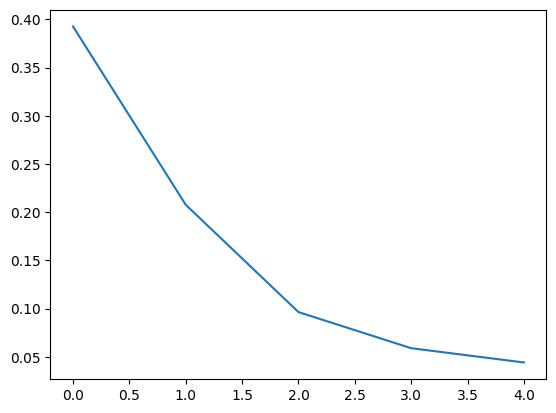

In [154]:
import matplotlib.pyplot as plt
plt.plot(history_df.loss);

# Check sentence

In [156]:
#preprocessing
import re
import pymorphy2
import nltk
from datetime import datetime 
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet
import matplotlib.pyplot as plt
import string
# pad the sequences to have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences


######## new
import itertools as itt
chunksize = 200
    
# vectorize a text corpus by turning each text into sentence of integers
max_len = 200
# tokenizer = Tokenizer(num_words=num_unique_words, oov_token=oov_token)
# tokenizer.fit_on_texts(X)


values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(df_val.text):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    tf.config.run_functions_eagerly(True)
    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
########
# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 69ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 45ms/step


2/2 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


2/2 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 43ms/step


In [157]:
# del(df_result)
df_result.head()

,text,time_elapsed_ms,label
0,ssbbw ivy davenport know weak big bubbly fart ...,618.0,0
1,start end text ready yeah okay name seth old s...,361.0,1
2,start end text fun nice show stuff okay good d...,425.6,0
3,brunette creampie mv iwc c mp,831.2,0
4,start end text see someone enjoying back home ...,338.8,1


In [158]:
df_val.head()

,time_spent_ms,text
0,100.0,ssbbw ivy davenport know weak big bubbly fart ...
1,4600.0,start end text ready yeah okay name seth old s...
2,2500.0,start end text fun nice show stuff okay good d...
3,0.0,brunette creampie mv iwc c mp
4,5800.0,start end text see someone enjoying back home ...


In [159]:
df_result.head()

,text,time_elapsed_ms,label
0,ssbbw ivy davenport know weak big bubbly fart ...,618.0,0
1,start end text ready yeah okay name seth old s...,361.0,1
2,start end text fun nice show stuff okay good d...,425.6,0
3,brunette creampie mv iwc c mp,831.2,0
4,start end text see someone enjoying back home ...,338.8,1


In [160]:
df_united = df_val.merge(df_result, right_on='text', left_on='text')
df_united['time_delta'] = df_united.time_spent_ms - df_united.time_elapsed_ms
df_united = df_united[['text', 'time_spent_ms', 'time_elapsed_ms', 'time_delta', 'label']]
df_united.drop_duplicates(['text'], keep='last', ignore_index=True, inplace=True)

In [161]:
df_united.head(20)

,text,time_spent_ms,time_elapsed_ms,time_delta,label
0,ssbbw ivy davenport know weak big bubbly fart ...,100.0,618.0,-518.0,0
1,start end text ready yeah okay name seth old s...,4600.0,361.0,4239.0,1
2,start end text fun nice show stuff okay good d...,2500.0,425.6,2074.4,0
3,brunette creampie mv iwc c mp,0.0,150.8,-150.8,0
4,start end text see someone enjoying back home ...,5800.0,338.8,5461.2,1
5,murder investigation part starring kobe lee wh...,600.0,368.6,231.4,0
6,bianca desperate blonde milf need help asap ge...,100.0,157.8,-57.8,0
7,milf blonde financial domination submissive sl...,100.0,338.2,-238.2,0
8,start end text ready yeah okay name seth old s...,3900.0,284.2,3615.8,1
9,extreme domination ballbusting piercings femal...,100.0,157.2,-57.2,1


In [162]:
df_united.to_csv('../datasets/last_pred_old.csv')

In [163]:
######## new
import itertools as itt
chunksize = 200
max_len = chunksize

# raw_text = "After a morning of horse-back riding, Sara Domina returns home with her boots dirtied, the soles soiled with .....Her slave is in waiting, unawares of what is about to happen to him ....."
raw_text = """nymphomaniac forced submission wmv"""

test_text_preprocessed = [clean_text(raw_text)]
# print(test_text_preprocessed)
values = []
columns = ['text', 'time_elapsed_ms','label']
for index, elem in enumerate(test_text_preprocessed):
    start_time = datetime.now() 
    cnt = itt.count()
    test_text_np = np.array([''.join(grp) for k, grp in itt.groupby(elem, key=lambda x: next(cnt)//chunksize%2)])
    tokenizer.fit_on_texts(test_text_np)
    test_sequences = tokenizer.texts_to_sequences(test_text_np)   
    test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")
#     print(test_text_np)
#     print('LEN', len(test_text_np))
#     print('test_sequences', test_sequences)
#     print('test_sequences_padded', test_sequences_padded)
    
    # for word in test_text_preprocessed:
    # Get max training sequence length
  

    tf.config.run_functions_eagerly(True)
    predictions = model.predict(test_sequences_padded)
    predictions = [1 if p > .5 else 0 for p in predictions]

    time_elapsed = datetime.now() - start_time 

#     print('Time elapsed (ms) {}'.format(time_elapsed.microseconds/1000))
#     print('Prediction:', max(predictions))
    if elem not in values:
#         print('**************', index, '~~~~~~~~~~~', elem, values[index-1])
        values.append([elem, round(time_elapsed.microseconds/1000, 1), max(predictions)])
        values[index][1] += round(time_elapsed.microseconds/1000, 1)
#         print('**************', index, '~~~~~~~~~~~', elem, '################', values[index][1])
df_result = pd.DataFrame(data=values, columns=columns)
df_result
# ####### new
# myseq = raw_text
# cnt = itt.count()
# test_text_np = np.array([''.join(grp) for k,grp in itt.groupby(myseq, key=lambda x: next(cnt)//chunksize%2)])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)
# #######

# test_text_np = np.array([test_text_preprocessed])
# test_sequences = tokenizer.texts_to_sequences(test_text_np)

1/1 [==============================] - 0s 41ms/step


,text,time_elapsed_ms,label
0,nymphomaniac forced submission wmv,170.4,0


In [164]:
test_text_np[0]

'nymphomaniac forced submission wmv'

In [165]:
test_sequences[0]

[7089, 180, 552, 194]

In [166]:
# for word in test_text_preprocessed:
# Get max training sequence length
max_len = 200

test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding="post", truncating="post")

In [167]:
print(test_text_np)
print(test_sequences)
print(test_sequences_padded)

['nymphomaniac forced submission wmv']
[[7089, 180, 552, 194]]
[[7089  180  552  194    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
 

In [168]:
start_time = datetime.now() 

predictions = model.predict(test_sequences_padded)
predictions = [1 if p > .5 else 0 for p in predictions]

time_elapsed = datetime.now() - start_time 

print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))


1/1 [==============================] - 0s 41ms/step
Time elapsed (hh:mm:ss.ms) 0:00:00.055507


In [169]:
max(predictions)

0

In [ ]:
# %%time

# predictions = model_new.predict(test_sequences_padded)
# predictions = [1 if p > .5 else 0 for p in predictions]